In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_columns')

In [3]:
seasons_df=pd.read_pickle('data/seasons_betting_constants_df.pkl')

In [4]:
#seasons_df=pd.get_dummies(seasons_df, columns=['HomeTeam', 'AwayTeam'])
seasons_df.drop(columns=['HomeTeam', 'AwayTeam'], inplace=True)

In [5]:
pd.set_option('future.no_silent_downcasting', True)
seasons_df=seasons_df.fillna(0)

In [6]:

label_encoder = LabelEncoder()
seasons_df['label'] = label_encoder.fit_transform(seasons_df['FTR'])

In [7]:
train=seasons_df[~(seasons_df['season']=='season23')]
train=train.copy()
train.drop(['Date','season'], axis=1, inplace=True)

In [8]:
X_train=train.drop(['label','FTR'], axis=1)
y_train=train['label']

In [9]:
test=seasons_df[seasons_df['season']=='season23']
test=test.copy()
test.drop(['season', 'FTR'], axis=1, inplace=True)

## Scaling

In [10]:
scaling_columns=X_train.columns

In [11]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [12]:
test=test.copy()
test[scaling_columns]=scaler.transform(test[scaling_columns])

In [13]:
test = test.sort_values('Date')
unique_dates = test['Date'].unique()

In [14]:
# Convert the data into PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long) 

In [15]:
# Create a DataLoader for batching (optional, but useful for large datasets)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [16]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        """
        Args:
            patience (int): How many epochs to wait after the last improvement.
            delta (float): Minimum change in validation loss to qualify as an improvement.
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Instantiate the early stopping object
early_stopping = EarlyStopping(patience=5, delta=0.001)

In [17]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(0.4)  # Dropout to prevent overfitting

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [18]:
class SimplifiedNeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimplifiedNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # Fewer neurons in the first layer
        self.fc2 = nn.Linear(128, 64)        # Second layer with fewer neurons
        self.fc3 = nn.Linear(64, output_dim) # Directly map to output classes
        self.dropout = nn.Dropout(0.2)      # Lower dropout rate (optional)

    def forward(self, x):
        x = F.relu(self.fc1(x))             # Apply ReLU after the first layer
        x = self.dropout(x)                 # Add dropout
        x = F.relu(self.fc2(x))             # Apply ReLU after the second layer
        x = self.fc3(x)                     # Output layer without activation (handled by loss function)
        return x

In [19]:
# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]  # Number of features
output_dim = 3  # Number of classes (update based on your data)


In [20]:
X_train_tensor.shape

torch.Size([7728, 53])

In [23]:
%%time 
import ipdb

# Your dataset and DataLoader setup here
X = X_train_tensor
y = y_train_tensor
#y=y.reset_index(drop=True)

# KFold cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds for cross-validation

# Initialize variables to track the performance across folds
fold_train_losses = []
fold_val_losses = []
fold_val_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    print(f"Fold {fold}/{kf.get_n_splits()}")
    #ipdb.set_trace()

    # Create train and validation sets for this fold
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    # Create DataLoader for this fold
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_fold, y_train_fold), batch_size=16, shuffle=True) #smaller batch sizes add more noise that can act as regularisation
    val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_fold, y_val_fold), batch_size=16, shuffle=False)

    # Initialize the model, loss function, and optimizer
    model = NeuralNetwork(input_dim=X_train_fold.shape[1], output_dim=3)  # Update output_dim based on your dataset
    #criterion = nn.CrossEntropyLoss()
    class_weights = {0: 1.5, 1: 1.5, 2: 1.0}  # Inverse proportional to class frequency
    #class_weights = {0: 1.0, 1: 1.0, 2: 1.0}  
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights.values())))

    #optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)  # AdamW recommended over Adam
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # Reduce LR every 3 epochs


    # Early stopping setup
    early_stopping = EarlyStopping(patience=5, delta=0.001)

    # Training loop for this fold
    epochs = 50
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        # Training step
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
        scheduler.step()  # Step the scheduler after each epoch

        # Average training loss for this epoch
        train_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}")

        # Validation step
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                outputs = model(X_val_batch)
                loss = criterion(outputs, y_val_batch)
                val_loss += loss.item()

                _, predicted_classes = torch.max(outputs, 1)
                acc = accuracy_score(y_val_batch, predicted_classes)
                val_acc += acc

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

        # Early stopping check
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

    # Track performance for this fold
    fold_train_losses.append(train_loss)
    fold_val_losses.append(val_loss)
    fold_val_accuracies.append(val_acc)

# After all folds, calculate the average performance
avg_train_loss = np.mean(fold_train_losses)
avg_val_loss = np.mean(fold_val_losses)
avg_val_acc = np.mean(fold_val_accuracies)

print(f"Average Train Loss: {avg_train_loss:.4f}")
print(f"Average Validation Loss: {avg_val_loss:.4f}")
print(f"Average Validation Accuracy: {avg_val_acc:.4f}")

Fold 1/5
Epoch [1/50], Train Loss: 1.0793
Validation Loss: 1.0738, Validation Accuracy: 0.4147
Epoch [2/50], Train Loss: 1.0714
Validation Loss: 1.0714, Validation Accuracy: 0.4509
Epoch [3/50], Train Loss: 1.0654
Validation Loss: 1.0716, Validation Accuracy: 0.4329
Epoch [4/50], Train Loss: 1.0567
Validation Loss: 1.0699, Validation Accuracy: 0.4393
Epoch [5/50], Train Loss: 1.0556
Validation Loss: 1.0695, Validation Accuracy: 0.4412
Epoch [6/50], Train Loss: 1.0531
Validation Loss: 1.0699, Validation Accuracy: 0.4425
Epoch [7/50], Train Loss: 1.0495
Validation Loss: 1.0699, Validation Accuracy: 0.4419
Epoch [8/50], Train Loss: 1.0496
Validation Loss: 1.0700, Validation Accuracy: 0.4419
Epoch [9/50], Train Loss: 1.0531
Validation Loss: 1.0700, Validation Accuracy: 0.4419
Early stopping triggered!
Fold 2/5
Epoch [1/50], Train Loss: 1.0777
Validation Loss: 1.0742, Validation Accuracy: 0.4331
Epoch [2/50], Train Loss: 1.0703
Validation Loss: 1.0757, Validation Accuracy: 0.4606
Epoch [3/5

### Looping through each date

In [24]:
# Initialize variables to track progress
predictions = []
accuracies = []
batchsizes = []
acc_batch = []
#thresholds = [0.5, 0.4, 0.5] 

for date in unique_dates:
    # Filter test data for the current date
    test_batch = test[test['Date'] == date]
    X_test_batch = test_batch.drop(columns=['label', 'Date'])
    y_test_batch = test_batch['label']
    
    # Convert test batch to tensors
    X_test_batch_tensor = torch.tensor(X_test_batch.values, dtype=torch.float32)
    y_test_batch_tensor = torch.tensor(y_test_batch.values, dtype=torch.long)
    
    # Make predictions for the current batch
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        y_pred_batch = model(X_test_batch_tensor)
    #uncomment this to get back to default
        _, predicted_classes = torch.max(y_pred_batch, 1)  # Get predicted class labels

    ################### comment this to get back to default
    #y_pred_proba = F.softmax(y_pred_batch, dim=1)  # Apply softmax to get probabilities
        
    # Adjust threshold for each class
    #predicted_classes = torch.argmax(y_pred_proba, dim=1)  # Default decision with max prob
        
    # Apply custom threshold for class 1 (for example, making class 1 more likely)
    #for i, threshold in enumerate(thresholds):
    #    predicted_classes[(y_pred_proba[:, i] > threshold)] = i
    ################
    
    # Collect predictions
    predictions.extend(predicted_classes.numpy())
    
    # Calculate and store metrics
    acc = accuracy_score(y_test_batch, predicted_classes.numpy())
    accuracies.append(acc)
    batchsizes.append(len(X_test_batch))
    acc_batch.append(acc * len(X_test_batch))

    print(f"Date: {date} - Accuracy: {acc:.4f} - BatchSize: {len(X_test_batch)}")

    # Update model with the current batch
    # Training mode
    model.train()  # Set the model to training mode
    
    # Concatenate current test data to the training data
    X_all = np.concatenate([X_train, X_test_batch.to_numpy()], axis=0)
    y_all = pd.concat([y_train, y_test_batch])

    # Convert to tensors
    X_all_tensor = torch.tensor(X_all, dtype=torch.float32)
    y_all_tensor = torch.tensor(y_all.values, dtype=torch.long)
    
    # Train the model with the updated data
    optimizer.zero_grad()  # Zero the gradients
    outputs = model(X_all_tensor)  # Forward pass
    loss = criterion(outputs, y_all_tensor)  # Compute loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights
    
    # Update training data
    X_train = X_all
    y_train = y_all

# Collect all predictions for further evaluation if needed
#test['predictions'] = predictions

Date: 2023-08-04 00:00:00 - Accuracy: 1.0000 - BatchSize: 1
Date: 2023-08-05 00:00:00 - Accuracy: 0.5000 - BatchSize: 8
Date: 2023-08-06 00:00:00 - Accuracy: 0.3333 - BatchSize: 3
Date: 2023-08-12 00:00:00 - Accuracy: 0.2500 - BatchSize: 12
Date: 2023-08-18 00:00:00 - Accuracy: 0.0000 - BatchSize: 1
Date: 2023-08-19 00:00:00 - Accuracy: 0.6000 - BatchSize: 10
Date: 2023-08-20 00:00:00 - Accuracy: 1.0000 - BatchSize: 1
Date: 2023-08-25 00:00:00 - Accuracy: 0.0000 - BatchSize: 1
Date: 2023-08-26 00:00:00 - Accuracy: 0.6000 - BatchSize: 10
Date: 2023-08-27 00:00:00 - Accuracy: 0.0000 - BatchSize: 1
Date: 2023-09-02 00:00:00 - Accuracy: 0.1667 - BatchSize: 12
Date: 2023-09-15 00:00:00 - Accuracy: 0.0000 - BatchSize: 2
Date: 2023-09-16 00:00:00 - Accuracy: 0.6667 - BatchSize: 9
Date: 2023-09-17 00:00:00 - Accuracy: 1.0000 - BatchSize: 1
Date: 2023-09-19 00:00:00 - Accuracy: 0.1667 - BatchSize: 6
Date: 2023-09-20 00:00:00 - Accuracy: 0.5000 - BatchSize: 6
Date: 2023-09-22 00:00:00 - Accuracy

In [25]:
# Print classification report
from sklearn.metrics import classification_report
print(classification_report(test['label'], predictions))

              precision    recall  f1-score   support

           0       0.40      0.62      0.48       177
           1       0.00      0.00      0.00       129
           2       0.55      0.62      0.58       246

    accuracy                           0.47       552
   macro avg       0.32      0.41      0.36       552
weighted avg       0.37      0.47      0.42       552



/home/benjamin/my_project_dir/my_project_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/benjamin/my_project_dir/my_project_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/benjamin/my_project_dir/my_project_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

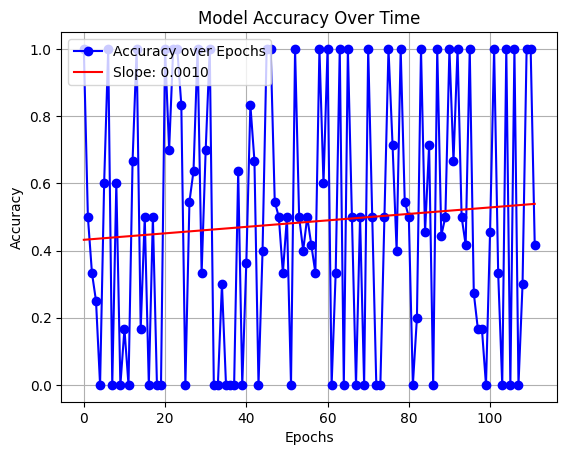

In [27]:
# Assuming accuracies is a list of accuracy values over epochs
epochs = np.arange(len(accuracies))  # Epochs are the x-values

# Calculate the slope using numpy's polyfit
slope, intercept = np.polyfit(epochs, accuracies, 1)

# Create the plot for the accuracy values
plt.plot(accuracies, marker='o', color='blue', label='Accuracy over Epochs')  # Add markers for clarity

# Plot the line representing the slope in red
plt.plot(epochs, slope * epochs + intercept, color='red', label=f'Slope: {slope:.4f}')

# Add labels and title
plt.title('Model Accuracy Over Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)  # Optional: Add a grid for better visualization

# Optional: Add legend
plt.legend()

# Display the plot
plt.show()

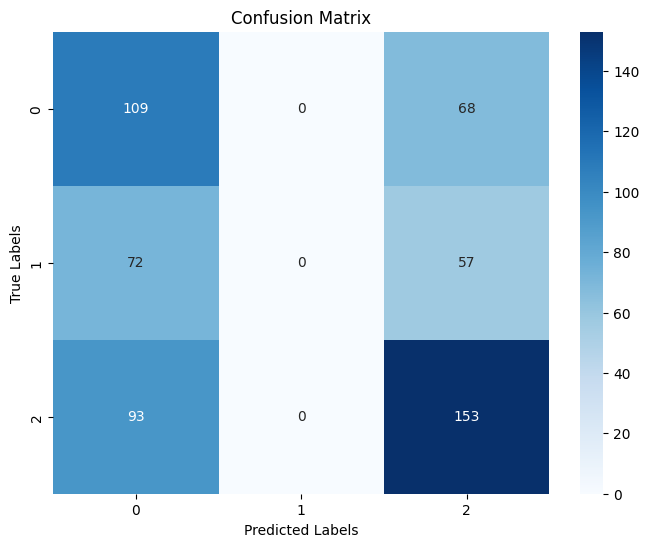

In [28]:
# Generate confusion matrix
cm = confusion_matrix(test['label'], predictions)



# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])

# Add labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show plot
plt.show()